A contextlib.context example
========



We all know and and appreciate the elengance of contextes, where cleanups are free.

In [1]:
in_file = 'sample_file.txt'
count = 0

with open(in_file, 'r') as sample_fd:
    for line in sample_fd:
        count += len(line)

print("Counted %d lines" % count)

Counted 106 lines


Same thing without using context

In [2]:
count = 0
sample_fd = open(in_file, 'r')
for line in sample_fd:
    count += len(line)

sample_fd.close()
print("Count %d lines" % count)

Count 106 lines


### Ugh.

### Writing context generators is also simple

https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers

Reimplementation of open context would look something like the following.


In [3]:

class open_read:
    def __init__(self, fname):
        self.fname = fname
        self.fd = None
    
    def __enter__(self):
        self.fd = open(self.fname, 'r')
        return self.fd
    
    def __exit__(self, type, value, traceback):
        self.fd.close()
        
count = 0
with open_read(in_file) as sample_read_fd:
    for line in sample_read_fd:
        count += len(line)

print("Counted %d with read-only context" % count)
        

Counted 106 with read-only context


As a former Java programmer I marvel at the simplicity of context protocol, but this is still a lot of code.

Fortunately there's a **contextlib** module in standard library that, predictably has **contextmanager** decorator, that does context managing. However the documentation is a little bit confusing.

    @contextmanager
    def tag(name):
        print "<%s>" % name
        yield
        print "</%s>" % name

    >>> with tag("h1"):
    ...    print "foo"
    ...
    <h1>
    foo
    </h1>
    
    The function being decorated must return a generator-iterator when called. This iterator must yield exactly one value, which will be bound to the targets in the with statement’s as clause, if any.


WUT?

This gets especially confusing because the most common use case for the context is to prepare an iterator object, so yield keyword kind of messes things up, and what if you want to iterate and build-up output inside of a context, where does yield go?



#### same example with @contextmanager

In [4]:
from contextlib import contextmanager


@contextmanager
def open_read_func(fname):
    fd = open(fname, 'r')
    try:
        yield fd
    finally:
        fd.close
        
count = 0
with open_read_func(in_file) as orf:
    for line in orf:
        count += len(line)

print("Counted %d with read-only context-managed context" % count)


Counted 106 with read-only context-managed context


Simple enough, but what if we want to *iterate* inside of a context?

Here's a problem -- let's say the content of the file we've been dealing thus far is very similar to a 3-letter overly verbose markup language that isn't worth mentioning, and we just want to get content items, and leave out everything else.

In [5]:
print(open(in_file, 'r').read())

begin
This is a sample file.
Just a regular sample file
end
begin
A sample file.
Nothing to see here.
end



### I just want to get the data between 'begin' and 'end' statements

In [6]:
@contextmanager
def overlyverbose_markup_preprocessor_parser(fname):
    # so let's pretend no other code exists and write our preprocessor function here
    def content_generator(file_desc):
        is_content = False
        output = ""
        for line in file_desc:
            if 'begin' in line:
                is_content = True
            elif 'end' in line:
                is_content = False
                yield output
                output = ""
            else:
                output += line
            
        
    
    # this is a copy of open_read_func
    fd = open(fname, 'r')
    try:
        yield content_generator(fd)
    finally:
        fd.close()
        
## Reading our content
with overlyverbose_markup_preprocessor_parser(in_file) as xml_content:
    for content_item in xml_content:
        print("----Content Item----")
        print(content_item)
        
    

----Content Item----
This is a sample file.
Just a regular sample file

----Content Item----
A sample file.
Nothing to see here.



### But in this case we're still opening and closing files manually instead of using context managers!

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

## (You know what is coming)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


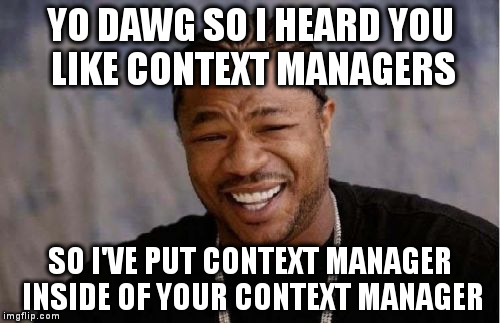

In [7]:
from IPython.display import Image
Image(filename="u7dry.jpg")

In [8]:
@contextmanager
def final_preprocessor_example(fname):
    #our new function
    def content_generator():
        with open(fname, 'r') as fd:
            is_content = False
            output = ""
            for line in fd:
                if 'begin' in line:
                    is_content = True
                elif 'end' in line:
                    is_content = False
                    yield output
                    output = ""
                else:
                    output += line
    # Now we're returning a function that calls a function that returns a generator
    # Let that sink in
    yield content_generator()

#Somehow everything still works
with final_preprocessor_example(in_file) as xml_content:
    for content_item in xml_content:
        print("----Content Item----")
        print(content_item)    
                

----Content Item----
This is a sample file.
Just a regular sample file

----Content Item----
A sample file.
Nothing to see here.



OK, so if we expand the code, we'll get the following

In [21]:
class preprocessor_context:
    
    def __init__(self, fname):
        self.fname = fname
    
    def __exit__(self, type, value, traceback):
        pass
    
    def __enter__(self):
        def content_generator():
            with open(self.fname, 'r') as fd:
                is_content = False
                output = ""
                for line in fd:
                    if 'begin' in line:
                        is_content = True
                    elif 'end' in line:
                        is_content = False
                        yield output
                        output = ""
                    else:
                        output += line
        
        return content_generator()
    
    
    
with preprocessor_context(in_file) as px:
    for content_item in px:
        print("----Content Item----")
        print(content_item)

----Content Item----
This is a sample file.
Just a regular sample file

----Content Item----
A sample file.
Nothing to see here.



So this also works, but we have `__exit__` method that does nothing, `__init__` method that only saves a variable and `__enter__` method that calls and returns the function defined inside of it.

This looks a lot like Facade pattern from Java, except I'm not trying to interface with anything that can be changed -- it's all my code.

The interface I'm trying to use is `with` statement. What if I just get rid of it?

In [22]:
def content_generator(fname):
    with open(fname, 'r') as fd:
        is_content = False
        output = ""
        for line in fd:
            if 'begin' in line:
                is_content = True
            elif 'end' in line:
                is_content = False
                yield output
                output = ""
            else:
                output += line

for item in content_generator(in_file):
    print("----Content Item----")
    print(item)

----Content Item----
This is a sample file.
Just a regular sample file

----Content Item----
A sample file.
Nothing to see here.



Everything works, with a lot less code.


The lesson for me -- even though context and iterators often go together, they are not the same thing.